In [1]:
cd ..

/Users/deepakduggirala/Documents/autonomous-robotics/bev-generation


https://ai4ce.github.io/V2X-Sim/data.html

In [2]:
import time
import zlib
from pathlib import Path
from itertools import islice

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import lmdb

from tqdm import tqdm

import utils
from utils import array_to_bytes, bytes_to_array
import nusc_utils

In [3]:
dataroot = Path('/Users/deepakduggirala/Documents/autonomous-robotics/V2X-Sim-2.0/').resolve()
# nuscenes = NuScenes(version='v2.0-mini', dataroot=str(dataroot), verbose=False)

In [4]:
class_to_rgb = {
    0: [255, 255, 255],  # Unlabeled
    1: [71, 141, 230],  # Vehicles
    2: [122, 217, 209],  # Sidewalk
    3: [145, 171, 100],  # Ground / Terrain
    4: [231, 136, 101],  # Road / Traffic light / Pole
    5: [142, 80, 204],  # Buildings
    6: [224, 8, 50],  # Pedestrian
    7: [106, 142, 34]  # Vegetation
    # 7: [102, 102, 156],  # Walls
    # 0: [55, 90, 80],  # Other
}

# Remap pixel values given by carla
classes_remap = {
    0: 0,  # Unlabeled (so that we don't forget this class)
    10: 1,  # Vehicles
    8: 2,  # Sidewalk
    14: 3,  # Ground (non-drivable)
    22: 3,  # Terrain (non-drivable)
    7: 4,  # Road
    6: 4,  # Road line
    18: 4,  # Traffic light
    5: 4,  # Pole
    1: 5,  # Building
    4: 6,  # Pedestrian
    9: 7,  # Vegetation
}

class_idx_to_name = {
    0: "Unlabeled",
    1: "Vehicles",
    2: "Sidewalk",
    3: "Ground & Terrain",
    4: "Road",
    5: "Buildings",
    6: "Pedestrian",
    7: "Vegetation",
}

## READ V2X BEV

In [5]:
def db_value_to_array(value):
    value_unzipped = zlib.decompress(value)
    return bytes_to_array(value_unzipped)

In [6]:
def color_bev(bev_top):
    H,W = bev_top.shape
    bev_rgb = np.zeros((H, W, 3), dtype=np.uint8)

    for cls_j in np.unique(bev_top):
        ii, jj = np.where(bev_top == cls_j)
        color = class_to_rgb[cls_j]
        bev_rgb[ii, jj, :] = color
    return bev_rgb

In [7]:
vehicle_id=1
gt_db_path = dataroot / Path(f'lmdb/samples/GT_BEV')
gt_db = lmdb.open(path=str(gt_db_path), readonly=True)

In [8]:
token = 'scene_1_000007'
token_bytes = str.encode(f'${token}_id_{vehicle_id}', 'utf-8')
token_bytes

b'$scene_1_000007_id_1'

In [9]:
with gt_db.begin() as txn:
    value = txn.get(token_bytes)
    bev_gt = db_value_to_array(value)
bev_gt.shape

(256, 256)

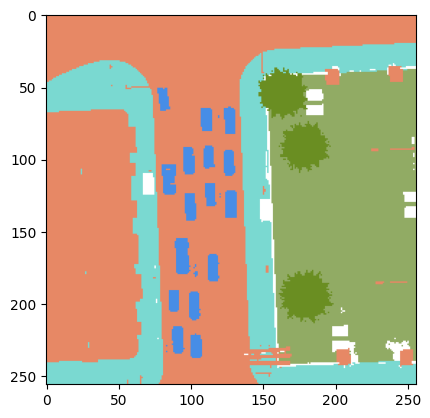

In [10]:
bev_rgb = color_bev(bev_gt)
plt.imshow(bev_rgb)

### Cropped - only regions infront of the vehicle

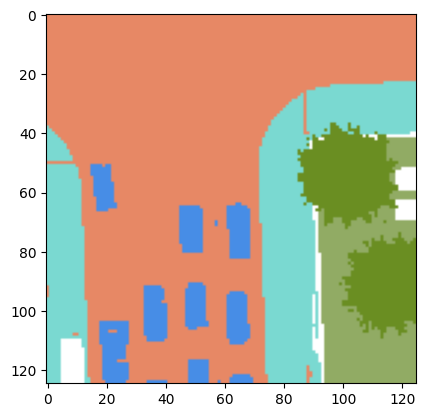

In [11]:
bev_rgb_cropped = bev_rgb[:125,62:187]
plt.imshow(bev_rgb_cropped)

In [12]:
bev_rgb_cropped.shape

(125, 125, 3)

## Color V2X GT BEV with same label colors as Nuscenes

In [13]:
v2x_nuscenes_remap = {
    1: 5, # vehicles -> car
    2: 3, # Sidewalk -> sidewalk
    3: 0, # Ground & Terrain -> Unlabelled
    4: 1, # Road -> drivable_area
    5: 0, # Buildings -> Unlabelled
    6: 10, # Pedestrian -> pedestrian
    7: 0,  # Vegetation -> Unlabelled
}

In [14]:
nusc_idx_to_color = {
    0: (0, 207, 191),
    1: (175, 0, 75),
    2: (75, 0, 75),
    3: (112, 180, 60),
    4: (255, 158, 0),
    5: (255, 99, 71),
    6: (255, 69, 0),
    7: (255, 140, 0),
    8: (233, 150, 70),
    9: (138, 43, 226),
    10: (255, 61, 99),
    11: (220, 20, 60),
    12: (47, 79, 79),
    13: (112, 128, 144)
}
color_map_gt = {i + 1: c for i, c in nusc_idx_to_color.items()}
color_map_gt[0] = [255, 255, 255]  # color areas without any class as white
color_map_gt[2] = color_map_gt[1]  # color ped_crossing with same color as drivable_area
color_map_gt[4] = [255, 255, 255]  # do not color "carpark_area" - will be white

In [15]:
def v2x_to_nusc(bev):
    bev_nusc = np.zeros_like(bev)

    for cls_i in np.unique(bev):
        cls_j = v2x_nuscenes_remap.get(cls_i, 0)
        ii, jj = np.where(bev == cls_i)
        bev_nusc[ii, jj] = cls_j
    return bev_nusc

In [16]:
bev_gt_nusc = v2x_to_nusc(bev_gt)
bev_gt_nusc_color = utils.color_components(bev_gt_nusc, color_map=color_map_gt)

(-0.5, 255.5, 255.5, -0.5)

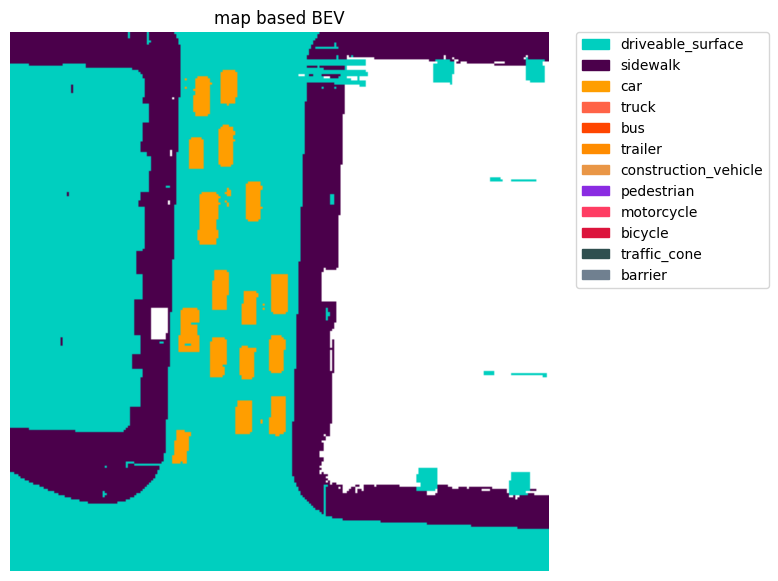

In [17]:
fig, axs = plt.subplots(figsize=(15, 7))

axs.imshow(np.flip(bev_gt_nusc_color, 0))
axs.set_title('map based BEV')
axs.axis('off')

legend_colors = [np.append(np.array(nusc_idx_to_color[idx]) / 255, 1) for idx in range(len(nusc_idx_to_color))]
patches = [mpatches.Patch(color=legend_colors[i], label=label)
           for i, label in enumerate(nusc_utils.NUSC_LIDAR_CLASS_NAMES) if i not in [1, 3]]
axs.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs.axis('off')